# !! Not Current !!


# ?1_fMRI_Correlations.ipynb

Original code from Eshin Jolly & modified for personal use




You'll need 2 things to do an ISC analysis:  

1) Nifti file(s) containing ROI masks within which to compute ISC - this can either be a single 4d file that several ROI masks within it, a single 3d file with just 1 ROI mask, a single 3d file within multiple ROIs indicated by different non-overlapping integer value at each voxel  

2) 4d Nifti files for all subjects to correlate

In [4]:
import nltools
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import os

% matplotlib inline

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Plot Video Splitting to verify
from nilearn import image
from nilearn import plotting
from nilearn import input_data

subjects = ['145', '157', '168', '184', '186', '200', '214', '216', '219', '220', '222', '223', '229', '245', '249', '253', '257', '263', '265', '267', '270', '277', '280', '282', '288']
for sub in subjects: 

    subject = 'sub-' + sub
    data_filepath = os.path.join("./data/", subject, "func/")
    bold_input = image.smooth_img("./data/"+ subject + "/func/" + subject + "_other_concat.nii.gz", fwhm=3)
    print(subject)
    print(bold_input.shape)
#     except: 
#         print(subject)
#         print("Didn't Work")

ValueError: File not found: './data/sub-145/func/sub-145_other_concat.nii.gz'

In [15]:
# Plot Video Splitting to verify
from nilearn import image
from nilearn import plotting
from nilearn import input_data


#Load original and cut data
bold_input = image.smooth_img("./data/sub-184/func/sub-184_other_concat.nii.gz", fwhm=3)

print(bold_input.shape)

#Guess auditiory cortex seed
aud_coords = [(-56,-4,-10),(56,-4,-10)]
labels = ['Auditory Cortex - L', 'Auditory Cortex - R']

#Make mask of auditory cortex
masker = input_data.NiftiSpheresMasker(
    aud_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=1)


time_series = masker.fit_transform(bold_input)

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)


ValueError: File not found: './data/sub-184/func/sub-184_other_concat.nii.gz'

IndexError: too many indices for array

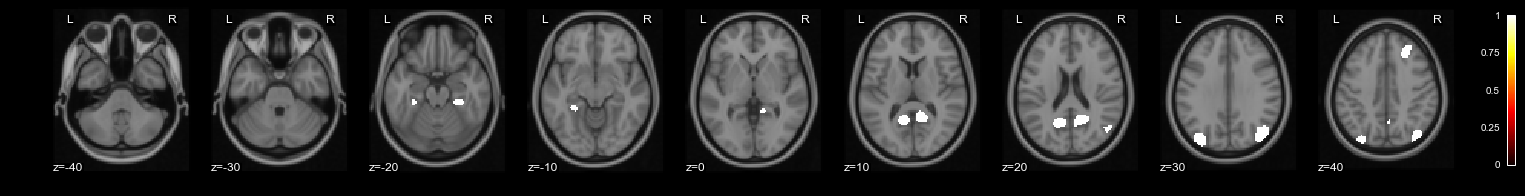

In [12]:
## Set up Folders

folder_path = "."

## Set up Mask

mask = 'vDMN.nii.gz'
mask_region = "vDMN"

# View Mask
mask = Brain_Data(data = folder_path + '/masked_csv/' + mask) # this now a 1d array of voxels containing 1's and 0s
mask.plot()


from nilearn.plotting import plot_glass_brain



In [ ]:
self_other = 'other'
subjects = ['145', '157', '168', '184', '186', '200', '214', '216', '219', '220', '222', '223', '229', '245', '249', '253', '257', '263', '265', '267', '270', '277', '280', '282', '288']
subjects =  ['145', '157', '168', '184',  '200', '214', '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277',  '282', '288']

num_subs = len(subjects)
subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'sub-' + subjects[0] + '_other_concat.nii.gz')
num_TRs = 470

subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 
for i, subject in enumerate(subjects):

    try:
        subject_path = os.path.join(folder_path,'data', 'sub-' + subject, 'func', 'sub-' + subject + '_other_concat.nii.gz')
        print(subject_path)

        # Load in their data
        sub_dat = Brain_Data(subject_path)

        # Extract mean time-series from ROI
        sub_roi = sub_dat.extract_roi(mask)

        data_frame = pd.DataFrame(sub_roi)

        output = os.path.join(folder_path, 'masked_csv', mask_region, 'sub-' + subject + '_other_concat' + mask_region + 'mask.csv')

        data_frame.to_csv(output, header=None)
    except: 
        print('subject ' + subject + " failed")



In [ ]:

for subject in subjects: 
    min = 5000
    csv_path = os.path.join(folder_path, 'masked_csv', mask_region, 'sub-' + subject + '_other_concat' + mask_region + 'mask.csv')
    try: 
        sub_roi = pd.read_csv(csv_path, header=None)
        print(sub_roi.shape)
    except: 
        print("")
    if (sub_roi.shape[0] < min): 
        min = sub_roi.shape[0] 
        
print(min)


In [ ]:
## Load data and compute ISC
self_other = 'other'

#Cutting off time series as a problem solivng measure
num_TRs=  448
subjects = ['145', '157', '168', '184', '186', '200', '214', '216', '219', '220', '222', '223', '229', '245', '249', '253', '257', '263', '265', '267', '270', '277', '280', '282', '288']
num_subs = len(subjects)



subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 


for i, subject in enumerate(subjects):
    csv_path = os.path.join(folder_path, 'masked_csv', mask_region, 'sub-' + subject + '_other_concat' + mask_region + 'mask.csv')

    print(subject)

    try: 
        # Load in their data
        sub_roi = pd.read_csv(csv_path, header=None)
        subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 0:num_TRs, 1] # just grab the numpy array values (normally just [1])
    except: pass


# Now compute pairwise correlations 
sub_corrs = 1 - pairwise_distances(subject_timeseres,metric='correlation') # I'm subtracting by 1 because pairwise_distance gives you correlation distances (i.e. values from 0-2), this just converts from -1 to 1

panda_corrs = pd.DataFrame(sub_corrs)
panda_corrs.columns = subjects
panda_corrs.index = subjects

pd.DataFrame(panda_corrs).to_csv('./masked_csv/' + \
                                 mask_region + '/' + \
                                 self_other +   \
                                 '_fMRIcorrelations.csv')



# Save it as an adjacency matrix
sub_ISC = Adjacency(data=sub_corrs)



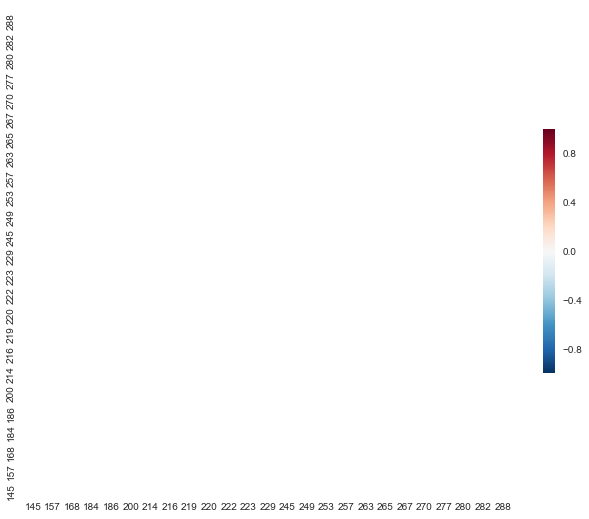

In [13]:
## Plot Group ISC

sns.set(style="white")

# Compute the correlation matrix
corr = sub_corrs
corr = pd.DataFrame(sub_corrs)

# Genesampling_rate a mask for the upper triangle
mask2 = np.zeros_like(corr, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(corr, vmax=.6, center=0,
            square=True, mask=mask2, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(subjects); 
ax.set_yticklabels(subjects); 

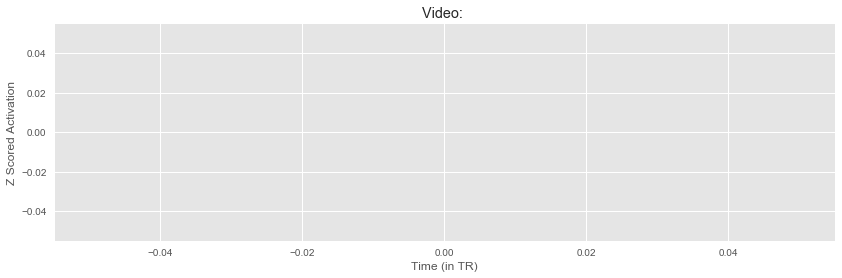

In [14]:
# Plot ISC Timeseries


plot_timeseries = pd.DataFrame(subject_timeseres).transpose().reset_index()

plot_timeseries = (plot_timeseries - plot_timeseries.mean()) / (plot_timeseries.max() - plot_timeseries.min())


plot_timeseries = plot_timeseries.loc[:, (plot_timeseries != 0).any(axis=0)]
plot_timeseries['index'] = plot_timeseries.index + 1

x = plot_timeseries['index']
y = plot_timeseries.drop(['index'], axis=1)

plt.figure(figsize=(14,4))
plt.style.use('ggplot')

plt.title("Video: " )
plt.ylabel('Z Scored Activation')
plt.xlabel('Time (in TR)')


plt.plot(x, y, '-', linewidth=3, alpha=.7);




x = plot_timeseries['index']
y = plot_timeseries[10]

plt.plot(x, y, '--', linewidth=3, alpha=.7);

In [ ]:
# # Compute Subject Level Z-Scored Correlations
# transformedcorrs = pd.DataFrame(sub_corrs)
# transformedcorrs = transformedcorrs.replace(1,nan)
# #transformedcorrs = 0.5*np.log((1+transformedcorrs)/(1-transformedcorrs))

# transformedcorrs.mean()

# transformedcorrs


Few other pointers:  

If you want to do ISC for multiple ROIs you'll probably want to do something like load in a single subject, loop over a `Brain_Data` object containing multiple ROIs, use the `extract` method to grab mean timeseries from each, then save all those to a single csv file for that subject using pandas or numpy. Then after you've done that for each subject just load in their csv files and proceed with correlating them as you want. This probably the fastest way to do it because very few computers can load say 30 subjects full time-series of a few minutes into RAM at once (unless maybe the time-series are very short). So this way just extracts all the ROIs for each subject first then lets you do whatever analyses you want on them. 